Notebook for plotting the results of the clustering measurements on the 4FS data. Just change the path of the cat_vars a few cells down to point to whichever set of results you wish to plot.

In [197]:
%load_ext autoreload
%autoreload

# import modules
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma as gamma_sc
from mpmath import gamma as gamma_mp

# import sys
# sys.path.append('../clustering_pipeline/')

# from imports import *
from data_io import load_object, read_to_df
from structures import catalogue_variables, results_powerspec, powerspec_measurement, CAMB_power
from aux import get_CAMB_power

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## global values to set e.g. font sizes and styles etc for the plots

# Defaults for font sizes, lines, etc.
rc_default = {}
rc_default['font.family'] = 'serif'
rc_default['font.size'] = 24
rc_default['axes.labelsize'] = 30
rc_default['axes.labelweight'] = 'normal'
rc_default['axes.linewidth'] = 1.0
rc_default['axes.titlesize'] = 30
rc_default['xtick.labelsize'] = 30
rc_default['ytick.labelsize'] = 30
rc_default['legend.fontsize'] = 24
# rc_default['figure.figsize'] = [400./72.27,(np.sqrt(5)-1.0)/2.0*400./72.27]
rc_default['figure.titlesize'] = 24
rc_default['savefig.dpi'] = 100
# Latex related
rc_default['text.usetex'] = True
rc_default['mathtext.fontset'] = 'custom'
rc_default['mathtext.rm'] = 'Bitstream Vera Sans'
rc_default['mathtext.it'] = 'Bitstream Vera Sans:italic'
rc_default['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams.update(rc_default)

In [9]:
# load the key paths / variables class object
cat_vars = load_object('catalogue_vars/2021_05_catalogue_vars')
cat_vars.__dict__

{'vars_name': '2021_05',
 'raw_input_file': 'cat-20210525',
 'raw_output_file': 'iwg2_20210610_run03fix4newtiling',
 'root_path': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/',
 'data_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Input/',
 'data_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Output/',
 'mask_path': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/survey_masks/',
 'randoms_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Input/randoms/',
 'randoms_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/data/2021_05_Output/randoms/',
 'results_input': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/results/2021_05_Input/',
 'results_output': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/results/2021_05_Output/',
 'plots_validation': '/cosma6/data/dp004/dc-prye1/4fs_clustering_project/plots_validation/2021_05/',
 'plots_results': '/cosma6/data/dp004/dc-prye1/4fs_cl

In [10]:
# First lets have a look at what the configuration space correlation function results tables look like for one of the tracers in the output catalogues

tracer = 'LyA'

# load the pickle objects containing the results
res_wt = load_object(cat_vars.results_output + 'results_' + tracer + '_wtheta')
res_xi = load_object(cat_vars.results_output + 'results_' + tracer + '_xi')
res_wp = load_object(cat_vars.results_output + 'results_' + tracer + '_wp')

print(res_wt.__dict__.keys(), '\n') # just prints all the variables of the class

# to access the data of the object just do e.g.:
test_result = res_wt.res_avg
print(test_result, '\n')

# the below calls the print function of the class that displays the stored data via a pandas DataFrame (aside from cov matrices)
res_wt.print_results()
res_xi.print_results()
res_wp.print_results()


dict_keys(['bin_mid', 'res_1', 'res_2', 'res_avg', 'err_1', 'err_2', 'err_avg', 'cov1', 'cov2', 'cov_avg', 'DD1', 'DD2', 'RR1', 'RR2', 'DR1', 'DR2', 'res_1_uncorr', 'res_2_uncorr', 'fibre_1_corr', 'fibre_2_corr']) 

[0.07420418 0.06803039 0.07922761 0.05392933 0.02872774 0.02486622
 0.01528955 0.01120302 0.00766842 0.00730306 0.00428415 0.00533931
 0.00550124 0.00436933 0.00547181 0.00449124 0.00295985 0.00115333
 0.00157298 0.00346996] 



,bin_mid,res_1,err_1,res_2,err_2,res_avg,err_avg,res_1_uncorr,fibre_1_corr,res_2_uncorr,fibre_2_corr,DD1,DD2,RR1,RR2,DR1,DR2
0,0.012143,0.083183,0.026826,0.058788,0.035152,0.074204,0.021326,0.029165,1.053251,0.002893,1.057112,1323.0,607.0,3.196737e+06,1.521219e+06,1.281860e+05,6.068900e+04
1,0.017219,0.056751,0.020517,0.097369,0.033089,0.068030,0.017437,-0.007162,1.064795,0.017408,1.079349,2554.0,1242.0,6.346453e+06,3.022984e+06,2.555520e+05,1.214870e+05
2,0.024267,0.086963,0.015812,0.070023,0.017248,0.079228,0.011655,0.036752,1.048706,0.013427,1.056526,5334.0,2464.0,1.268205e+07,6.036051e+06,5.108230e+05,2.422720e+05
3,0.034331,0.058664,0.014254,0.048292,0.015555,0.053929,0.010509,0.015321,1.043237,0.018963,1.029142,10354.0,4948.0,2.531670e+07,1.205883e+07,1.016137e+06,4.839220e+05
4,0.048470,0.017059,0.009352,0.035113,0.006918,0.028728,0.005562,-0.009440,1.026988,0.013428,1.021637,20236.0,9832.0,5.051381e+07,2.406198e+07,2.031792e+06,9.662610e+05
5,0.068404,0.021187,0.005375,0.035041,0.008938,0.024866,0.004606,0.003188,1.018030,0.011799,1.023094,41014.0,19681.0,1.007047e+08,4.796522e+07,4.058145e+06,1.931779e+06
6,0.096757,0.013874,0.005324,0.017624,0.006836,0.015290,0.004200,0.000441,1.013457,0.006740,1.010851,81674.0,39050.0,2.005448e+08,9.549369e+07,8.092487e+06,3.849146e+06
7,0.136569,0.005794,0.004047,0.016241,0.003906,0.011203,0.002810,-0.000108,1.005905,0.008609,1.007584,162909.0,78032.0,3.994744e+08,1.901789e+08,1.613506e+07,7.671536e+06
8,0.192908,0.004959,0.003460,0.011371,0.004045,0.007668,0.002629,0.000248,1.004711,0.002824,1.008523,324102.0,154630.0,7.943289e+08,3.782278e+08,3.208612e+07,1.527359e+07
9,0.272663,0.006792,0.001916,0.008805,0.003285,0.007303,0.001655,-0.000195,1.006973,0.003283,1.005494,644716.0,307304.0,1.576856e+09,7.499292e+08,6.377535e+07,3.031196e+07


,bin_mid,res_1,err_1,res_2,err_2,res_avg,err_avg,DD1,DD2,RR1,RR2,DR1,DR2
0,5.322730,1.188550,0.000056,1.182859,0.000016,1.183303,0.000016,349.0,169.0,396320.0,192759.0,15769.0,7658.0
1,5.954872,1.013420,0.000039,1.055638,0.000019,1.047697,0.000017,460.0,229.0,559942.0,270789.0,22622.0,11037.0
2,6.683671,0.775235,0.000052,1.097280,0.000019,1.057554,0.000018,569.0,327.0,788073.0,382158.0,31748.0,15444.0
3,7.502308,0.617444,0.000071,0.807080,0.000019,0.794268,0.000019,737.0,394.0,1111078.0,538883.0,45073.0,21612.0
4,8.408271,0.535881,0.000067,0.672148,0.000026,0.654876,0.000024,983.0,520.0,1568434.0,758472.0,63370.0,30774.0
5,9.465272,0.485057,0.000077,0.495536,0.000027,0.494407,0.000025,1341.0,650.0,2211049.0,1071541.0,89388.0,43106.0
6,10.601273,0.412561,0.000151,0.424899,0.000044,0.423942,0.000042,1795.0,878.0,3118606.0,1507887.0,125871.0,60993.0
7,11.884690,0.329143,0.000101,0.335627,0.000045,0.334578,0.000041,2376.0,1159.0,4391636.0,2128123.0,177140.0,85948.0
8,13.329038,0.237471,0.000155,0.283234,0.000044,0.279872,0.000042,3134.0,1561.0,6192236.0,2995445.0,250532.0,120661.0
9,14.977744,0.202753,0.000200,0.206290,0.000055,0.206039,0.000053,4276.0,2082.0,8718682.0,4218902.0,352097.0,170725.0


,bin_mid,res_1,err_1,res_2,err_2,res_avg,err_avg,DD1,DD2,RR1,RR2,DR1,DR2
0,5.296269,23.670681,2.443338,24.396524,4.804509,23.819828,2.177888,3080.0,1510.0,5809168.0,2832086.0,117296.0,57134.0
1,5.942511,16.516856,1.405074,23.111497,4.033243,17.230587,1.326863,3606.0,1882.0,7313240.0,3559830.0,147619.0,72075.0
2,6.667607,17.661026,2.666279,24.722044,2.575422,21.313891,1.852386,4598.0,2362.0,9203342.0,4479752.0,185880.0,89603.0
3,7.481178,17.614378,2.223284,20.279131,2.640476,18.719853,1.700702,5796.0,2894.0,11574962.0,5633624.0,234360.0,113957.0
4,8.394020,13.509426,2.507564,15.862158,2.511448,14.683972,1.774487,6944.0,3502.0,14579350.0,7076032.0,293991.0,143867.0
5,9.418245,16.707328,0.833771,16.278741,2.205999,16.653757,0.779924,9072.0,4358.0,18337648.0,8908138.0,370718.0,179401.0
6,10.567445,13.676793,1.612889,13.025621,1.927494,13.408618,1.236956,11014.0,5318.0,23061490.0,11193034.0,465406.0,226176.0
7,11.856869,10.066434,1.370508,13.570927,1.700971,11.445944,1.067202,13270.0,6720.0,29014788.0,14075340.0,584340.0,284240.0
8,13.303625,9.770304,1.361324,10.890857,1.929493,10.142714,1.112340,16730.0,8182.0,36500290.0,17692430.0,737350.0,356777.0
9,14.926913,8.665461,0.856808,9.947197,1.539984,8.968438,0.748725,20752.0,10156.0,45876316.0,22228126.0,926436.0,447842.0


In [158]:
%%time

# look at some key properties of the input and output catalogues
for tracer in cat_vars.tracers:
    target_in = cat_vars.data_input + 'input_reduced_' + tracer + '.fits'
    target_out = cat_vars.data_output + 'output_reduced_' + tracer + '.fits'
#     rand_in = read_to_df(cat_vars.randoms_input + 'table_' + tracer + '.fits')
#     rand_out = read_to_df(cat_vars.randoms_output + 'table_' + tracer + '.fits')
    df_in = read_to_df(target_in)
    df_out = read_to_df(target_out)
    N_in = len(df_in)
    N_out = len(df_out)
    n_bar = N_out / 7500
#     print(np.amin(df_out['REDSHIFT_ESTIMATE'].values), np.amax(df_out['REDSHIFT_ESTIMATE'].values))
    print('For %s there are %s input and %s output targets (%s %% completeness). Number density per sq.deg. = %s'%(tracer, N_in, N_out, round(N_out*100/N_in,1), n_bar))
#     plt.figure()
#     plt.title('%s'%(tracer))
#     plt.hist(df_out['REDDENING'].values, bins=50)
#     plt.show()
#     print(df_in.columns)
#     print(df_out.columns)
#     print(rand_in.columns)
#     print(rand_out.columns)
    

For BG there are 1892657 input and 1415183 output targets (74.8 % completeness). Number density per sq.deg. = 188.69106666666667
For LRG there are 3023501 input and 1953468 output targets (64.6 % completeness). Number density per sq.deg. = 260.4624
For QSO there are 1057486 input and 787016 output targets (74.4 % completeness). Number density per sq.deg. = 104.93546666666667
For LyA there are 375468 input and 300587 output targets (80.1 % completeness). Number density per sq.deg. = 40.078266666666664
CPU times: user 7.16 s, sys: 2.62 s, total: 9.78 s
Wall time: 9.8 s


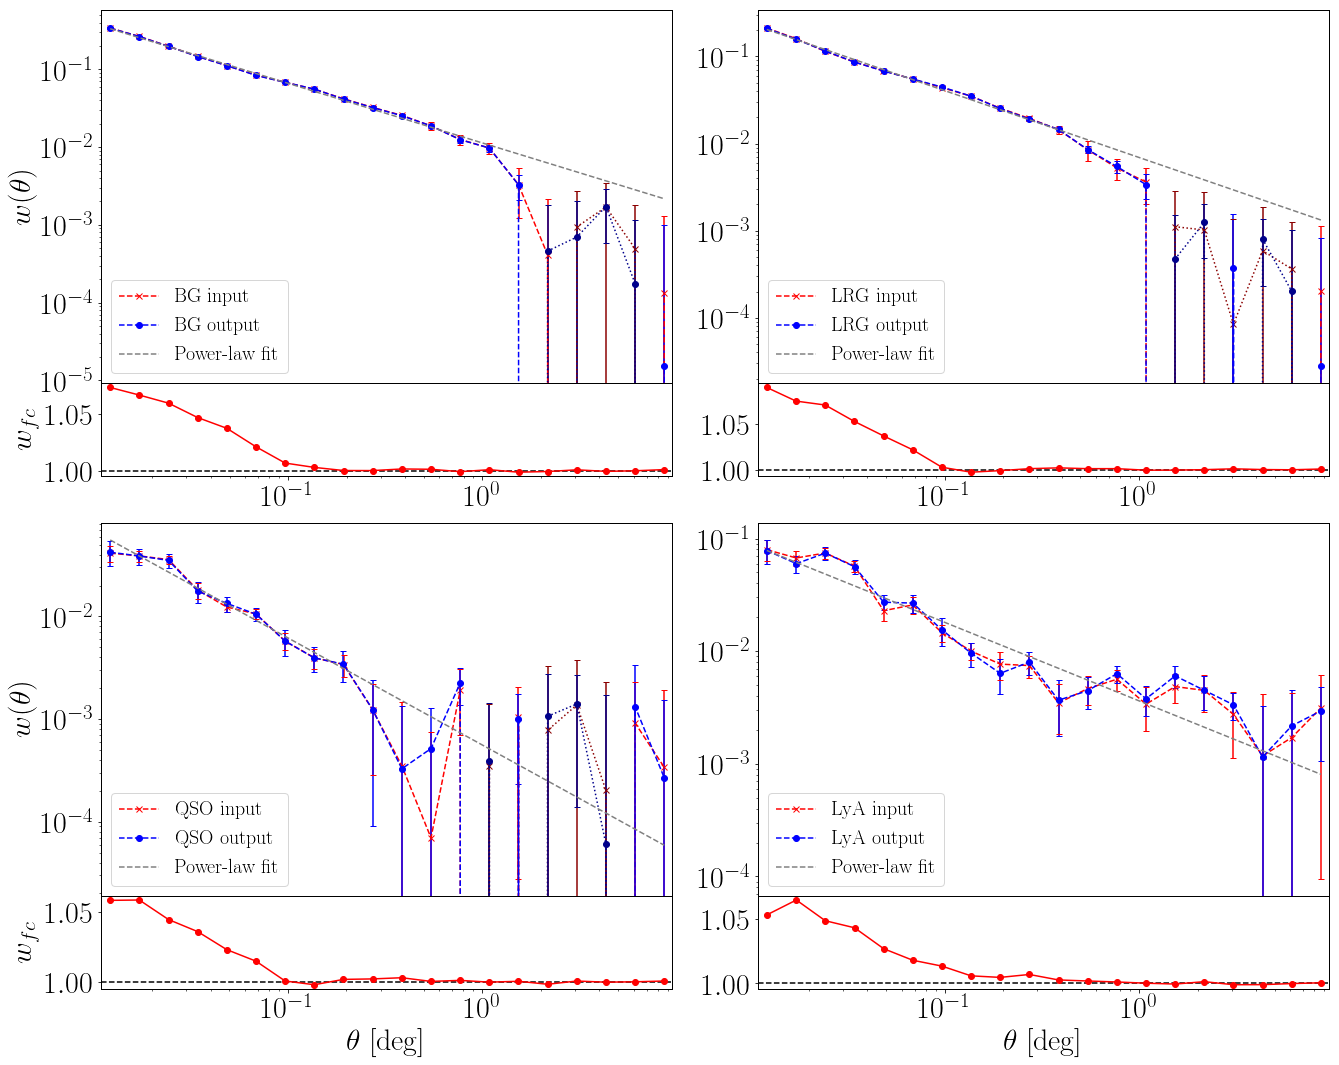

In [319]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(22, 18))

# simple power law to fit correlation functions to
def ang_power_law_fit(theta, A_w, gamma):
    return A_w * (theta)**(1-gamma)

outer = gridspec.GridSpec(2, 2, wspace=0.15, hspace=0.1)

for i in range(4):
    tracer = cat_vars.tracers[i]
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[i], wspace=0., hspace=0., height_ratios=[4,1])
    
    # load and get the data to plot
    results_file_in = cat_vars.results_input + 'results_' + tracer +'_wtheta'
    results_file_out = cat_vars.results_output + 'results_' + tracer +'_wtheta'
    res_wt_in = load_object(results_file_in)
    res_wt_out = load_object(results_file_out)
    wt_in_theta = res_wt_in.bin_mid
    wt_in_res = res_wt_in.res_avg
    wt_in_err = res_wt_in.err_avg
    wt_out_theta = res_wt_out.bin_mid
    wt_out_res = res_wt_out.res_avg
    wt_out_err = res_wt_out.err_avg
    w_fc_1 = res_wt_out.fibre_1_corr
    w_fc_2 = res_wt_out.fibre_2_corr
    
    # do a simple power law fit on the output data
    popt, pcov = curve_fit(ang_power_law_fit, wt_out_theta[wt_out_res>0], wt_out_res[wt_out_res>0], sigma=wt_out_err[wt_out_res>0])
    A_err = np.sqrt(pcov[0,0])
    pow_err = np.sqrt(pcov[1,1])
#     print("{0:.2e}, {1:.2e}, {2}, {3}".format(popt[0], A_err, popt[1], pow_err))
    
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        ax.set_xscale('log')
    
        # upper plot
        if j == 0:
            ax.set_yscale('log')
            ax.set_xticks([])
            ax.set_xlim(min(wt_out_theta)*0.9, max(wt_out_theta)*1.1)
            if i in [0,2]:
                ax.set_ylabel(r'$w(\theta)$')
            
            # plot the real-splace measurements
            ax.errorbar(wt_in_theta[wt_in_res>0], wt_in_res[wt_in_res>0], yerr=wt_in_err[wt_in_res>0], capsize=3, color='red', ls='')
            ax.errorbar(wt_in_theta[wt_in_res<0], -wt_in_res[wt_in_res<0], yerr=wt_in_err[wt_in_res<0], capsize=3, color='darkred', ls='')
            ax.errorbar(wt_out_theta[wt_out_res>0], wt_out_res[wt_out_res>0], yerr=wt_out_err[wt_out_res>0], capsize=3, color='blue', ls='')
            ax.errorbar(wt_out_theta[wt_out_res<0], -wt_out_res[wt_out_res<0], yerr=wt_out_err[wt_out_res<0], capsize=3, color='darkblue', ls='')

            ax.plot(wt_in_theta, wt_in_res, marker='x', color='red', ls='--', label='%s input'%(tracer))
            ax.plot(wt_in_theta, -wt_in_res, marker='x', color='darkred', ls=':')
            ax.plot(wt_out_theta, wt_out_res, marker='o', color='blue', ls='--', label='%s output'%(tracer))
            ax.plot(wt_out_theta, -wt_out_res, marker='o', color='darkblue', ls=':')
            
            text_label = r"Power-law fit, $A_\omega$ = {0:.1e}, $\gamma$ = {1}".format(popt[0], round(popt[1],2))
            ax.plot(wt_out_theta, ang_power_law_fit(wt_out_theta, popt[0], popt[1]), color='grey', ls='--', label='Power-law fit')#text_label)
            
            
            ax.legend(fontsize=20, loc=3)
        
        # lower plot
        else:
            ax.axhline(1, c='black', ls='--')
            ax.set_xlim(min(wt_out_theta)*0.9, max(wt_out_theta)*1.1)
            ax.plot(wt_out_theta, w_fc_1, marker='o', ls='-', c='red')

            if i in [2,3]:
                ax.set_xlabel(r'$\theta$ [deg]')
            if i in [0,2]:
                ax.set_ylabel('$w_{fc}$')
            
            

        fig.add_subplot(ax)


plt.savefig(cat_vars.plots_results + 'results_wtheta_fc.pdf', dpi=150, bbox_inches='tight')
plt.show()

5.09e+00, 2.32e-02, 1.6173695169867686, 0.023580706798654913
6.43e+00, 2.42e-02, 1.576163141978592, 0.01175945931427771
5.30e+00, 7.18e-02, 1.3853073684215607, 0.011962365774828678
6.15e+00, 2.14e-01, 1.4949311378259604, 0.03066186333167916


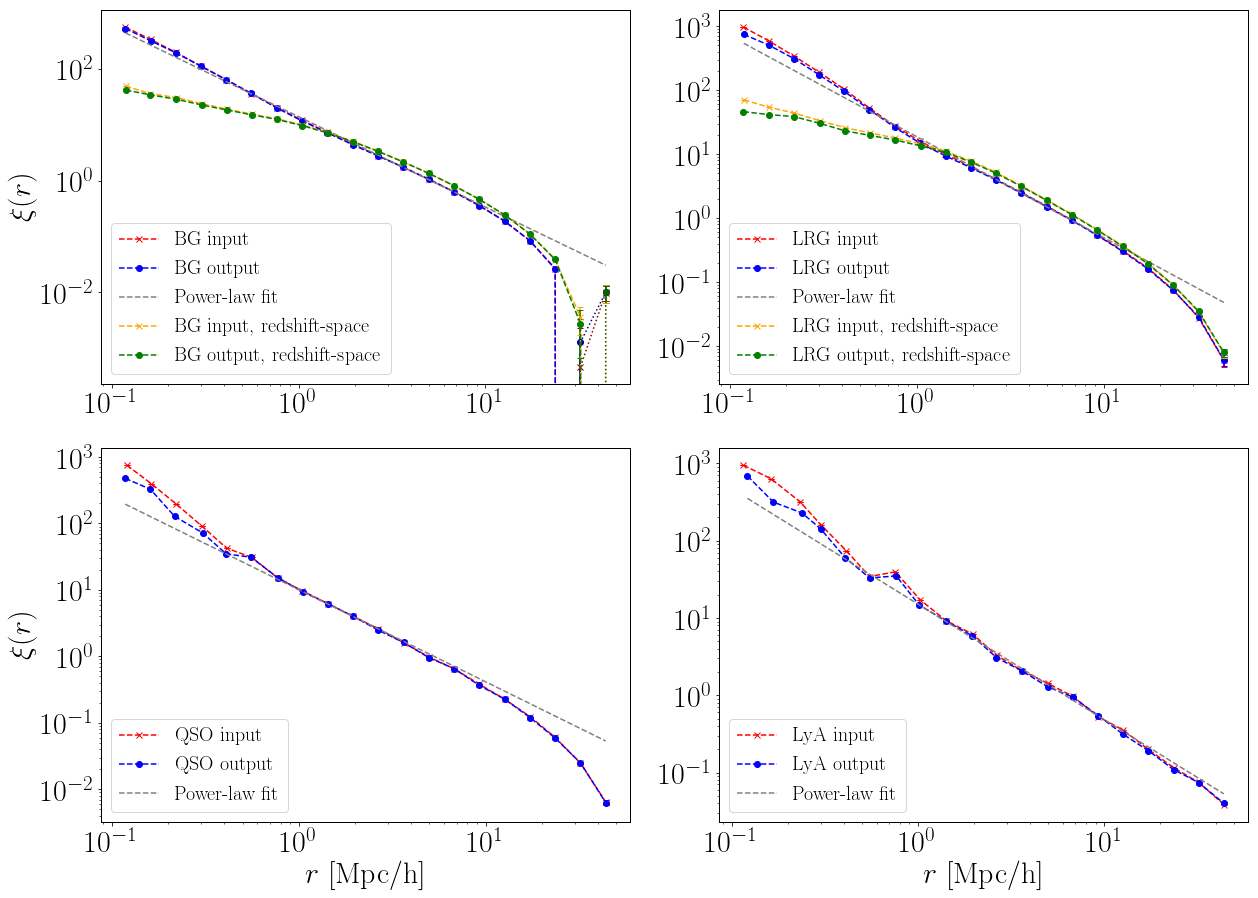

CPU times: user 8.84 s, sys: 5.87 s, total: 14.7 s
Wall time: 6.21 s


In [335]:
%%time

# for loop to plot the xi(r) results for the 4 tracers

# simple power law to fit correlation functions to
def xi_power_law_fit(r, r_0, gamma):
    return (r_0/r)**gamma

r_fit = np.zeros(4)
gamma_fit = np.zeros(4)


plt.figure(figsize=(18,13))

for i, tracer in enumerate (cat_vars.tracers):
    
    plt.subplot(2,2,i+1)
    
    if i in [0,2]:
        plt.ylabel(r'$\xi(r)$')
    if i in [2,3]:
        plt.xlabel(r'$r$ [Mpc/h]')
    plt.yscale('log')
    plt.xscale('log')
    
    # load the real-space data
    results_file_in = cat_vars.results_input + 'results_' + tracer + '_xi'
    res_xi_in = load_object(results_file_in)
    results_file_out = cat_vars.results_output + 'results_' + tracer + '_xi'
    res_xi_out = load_object(results_file_out)
    xi_in_r = res_xi_in.bin_mid
    xi_in_res = res_xi_in.res_avg
    xi_in_err = res_xi_in.err_avg
    xi_out_r = res_xi_out.bin_mid
    xi_out_res = res_xi_out.res_avg
    xi_out_err = res_xi_out.err_avg
    
    # do a simple power law fit on the output data
    if tracer in ['BG', 'LRG']:
        r_min = 3 # minimum r to be used ror fit
    else:
        r_min = 1
    popt, pcov = curve_fit(xi_power_law_fit, xi_out_r[(xi_out_res>0) & (xi_out_r>=r_min)], xi_out_res[(xi_out_res>0) & (xi_out_r>=r_min)], sigma=xi_out_err[(xi_out_res>0) & (xi_out_r>=r_min)])
    r_fit[i] = popt[0]
    gamma_fit[i] = popt[1]
    r0_err = np.sqrt(pcov[0,0])
    pow_err = np.sqrt(pcov[1,1])
#     print(r0_err, pow_err)
    A_err = np.sqrt(pcov[0,0])
    pow_err = np.sqrt(pcov[1,1])
    print("{0:.2e}, {1:.2e}, {2}, {3}".format(popt[0], A_err, popt[1], pow_err))
    
    # plot the real space data
    plt.errorbar(xi_in_r[xi_in_res>0], xi_in_res[xi_in_res>0], yerr=xi_in_err[xi_in_res>0], capsize=3, color='red', ls='')
    plt.errorbar(xi_in_r[xi_in_res<0], -xi_in_res[xi_in_res<0], yerr=xi_in_err[xi_in_res<0], capsize=3, color='darkred', ls='')
    plt.errorbar(xi_out_r[xi_out_res>0], xi_out_res[xi_out_res>0], yerr=xi_out_err[xi_out_res>0], capsize=3, color='blue', ls='')
    plt.errorbar(xi_out_r[xi_out_res<0], -xi_out_res[xi_out_res<0], yerr=xi_out_err[xi_out_res<0], capsize=3, color='darkblue', ls='')
    plt.plot(xi_in_r, xi_in_res, marker='x', color='red', ls='--', label='%s input'%(tracer))
    plt.plot(xi_in_r, -xi_in_res, marker='x', color='darkred', ls=':')
    plt.plot(xi_out_r, xi_out_res, marker='o', color='blue', ls='--', label='%s output'%(tracer))
    plt.plot(xi_out_r, -xi_out_res, marker='o', color='darkblue', ls=':')
    
    text_label = r"Power-law fit, $r_0$ = {0}, $\gamma$ = {1}".format(round(popt[0],1), round(popt[1],2))
    plt.plot(xi_out_r, xi_power_law_fit(xi_out_r, popt[0], popt[1]), color='grey', ls='--', label='Power-law fit')#text_label)
    
    
    # load and plot the redshift-space data
    if tracer in ['BG', 'LRG']:
        results_file_in = cat_vars.results_input + 'results_' + tracer + '_xi' + '_zspace'
        res_xi_in = load_object(results_file_in)
        results_file_out = cat_vars.results_output + 'results_' + tracer + '_xi' + '_zspace'
        res_xi_out = load_object(results_file_out)
        xi_in_r = res_xi_in.bin_mid
        xi_in_res = res_xi_in.res_avg
        xi_in_err = res_xi_in.err_avg
        xi_out_r = res_xi_out.bin_mid
        xi_out_res = res_xi_out.res_avg
        xi_out_err = res_xi_out.err_avg
        plt.errorbar(xi_in_r[xi_in_res>0], xi_in_res[xi_in_res>0], yerr=xi_in_err[xi_in_res>0], capsize=3, color='orange', ls='')
        plt.errorbar(xi_in_r[xi_in_res<0], -xi_in_res[xi_in_res<0], yerr=xi_in_err[xi_in_res<0], capsize=3, color='darkorange', ls='')
        plt.errorbar(xi_out_r[xi_out_res>0], xi_out_res[xi_out_res>0], yerr=xi_out_err[xi_out_res>0], capsize=3, color='green', ls='')
        plt.errorbar(xi_out_r[xi_out_res<0], -xi_out_res[xi_out_res<0], yerr=xi_out_err[xi_out_res<0], capsize=3, color='darkgreen', ls='')
        plt.plot(xi_in_r, xi_in_res, marker='x', color='orange', ls='--', label='%s input, redshift-space'%(tracer))
        plt.plot(xi_in_r, -xi_in_res, marker='x', color='darkorange', ls=':')
        plt.plot(xi_out_r, xi_out_res, marker='o', color='green', ls='--', label='%s output, redshift-space'%(tracer))
        plt.plot(xi_out_r, -xi_out_res, marker='o', color='darkgreen', ls=':')
    

    plt.legend(loc=3, fontsize=20)
    
plt.tight_layout()
# plt.savefig(cat_vars.plots_results + 'results_xi.pdf', dpi=150, bbox_inches='tight')
plt.savefig(cat_vars.plots_results + 'results_xi_new.pdf', dpi=150, bbox_inches='tight')
plt.show()

4.19e+00, 8.50e-02, 1.81, 0.02
5.17e+00, 1.23e-01, 1.85, 0.03
4.36e+00, 1.91e-01, 1.9, 0.05
5.28e+00, 1.33e-01, 1.72, 0.03


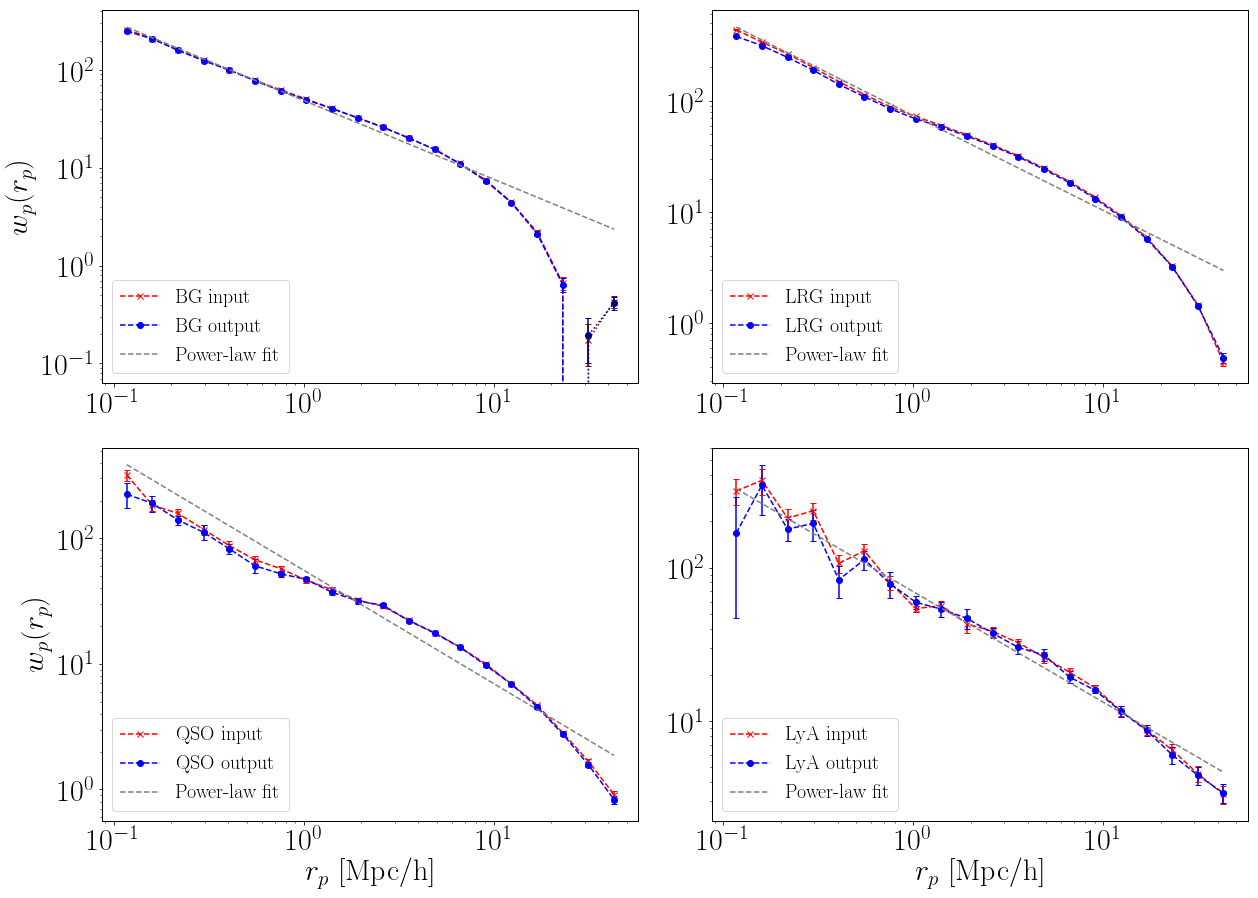

CPU times: user 8.04 s, sys: 5.54 s, total: 13.6 s
Wall time: 4.51 s


In [350]:
%%time

# simple power law to fit correlation functions to
def wp_power_law_fit(r_p, r_0, gamma):
    return r_p*((r_0/r_p)**gamma)*gamma_frac(gamma)

def gamma_frac(gamma):
    return (gamma_sc(1/2)*gamma_sc(0.5*(gamma-1)))/(gamma_sc(gamma/2))



# for loop to plot the w_p(r_p) results for the 4 tracers

plt.figure(figsize=(18,13))

for i, tracer in enumerate (cat_vars.tracers):
    
    results_file_in = cat_vars.results_input + 'results_' + tracer + '_wp'
    res_wp_in = load_object(results_file_in)
    results_file_out = cat_vars.results_output + 'results_' + tracer + '_wp'
    res_wp_out = load_object(results_file_out)
    
    plt.subplot(2,2,i+1)
#     plt.title('%s'%(tracer))
    if i in [0,2]:
        plt.ylabel(r'$w_p(r_p)$')
    if i in [2,3]:
        plt.xlabel(r'$r_p$ [Mpc/h]')
    plt.yscale('log')
    plt.xscale('log')
    
    wp_in_r = res_wp_in.bin_mid
    wp_in_res = res_wp_in.res_avg
    wp_in_err = res_wp_in.err_avg
    wp_out_r = res_wp_out.bin_mid
    wp_out_res = res_wp_out.res_avg
    wp_out_err = res_wp_out.err_avg
    

    popt, pcov = curve_fit(wp_power_law_fit, wp_out_r[(wp_out_res>0)], wp_out_res[(wp_out_res>0)], p0=(4, 1.2), sigma=wp_out_err[(wp_out_res>0)])
    A_err = np.sqrt(pcov[0,0])
    pow_err = np.sqrt(pcov[1,1])
    print("{0:.2e}, {1:.2e}, {2}, {3}".format(round(popt[0],3), round(A_err,3), round(popt[1],2), round(pow_err,2)))
    
    plt.errorbar(wp_in_r[wp_in_res>0], wp_in_res[wp_in_res>0], yerr=wp_in_err[wp_in_res>0], capsize=3, color='red', ls='')
    plt.errorbar(wp_in_r[wp_in_res<0], -wp_in_res[wp_in_res<0], yerr=wp_in_err[wp_in_res<0], capsize=3, color='darkred', ls='')
    plt.errorbar(wp_out_r[wp_out_res>0], wp_out_res[wp_out_res>0], yerr=wp_out_err[wp_out_res>0], capsize=3, color='blue', ls='')
    plt.errorbar(wp_out_r[wp_out_res<0], -wp_out_res[wp_out_res<0], yerr=wp_out_err[wp_out_res<0], capsize=3, color='darkblue', ls='')
    
    plt.plot(wp_in_r, wp_in_res, marker='x', color='red', ls='--', label='%s input'%(tracer))
    plt.plot(wp_in_r, -wp_in_res, marker='x', color='darkred', ls=':')
    plt.plot(wp_out_r, wp_out_res, marker='o', color='blue', ls='--', label='%s output'%(tracer))
    plt.plot(wp_out_r, -wp_out_res, marker='o', color='darkblue', ls=':')
    
#     text_label = r"Power-law fit, $r_0$ = {0}, $\gamma$ = {1}".format(round(popt[0],1), round(popt[1],2))
    text_label= "Power-law fit"
    plt.plot(wp_out_r, wp_power_law_fit(wp_out_r, popt[0], popt[1]), color='grey', ls='--', label=text_label)
#     text_label = r"Power-law fit, $r_0$ = {0}, $\gamma$ = {1}".format(round(r_fit[i],1), round(gamma_fit[i],2))
#     plt.plot(wp_out_r, wp_power_law_fit(wp_out_r, r_fit[i], gamma_fit[i]), color='grey', ls='--', label=text_label)

#     # load and plot the redshift-space data
#     if tracer in ['BG', 'LRG']:
#         results_file_in = cat_vars.results_input + 'results_' + tracer + '_wp' + '_zspace'
#         res_wp_in = load_object(results_file_in)
#         results_file_out = cat_vars.results_output + 'results_' + tracer + '_wp' + '_zspace'
#         res_wp_out = load_object(results_file_out)
#         wp_in_r = res_wp_in.bin_mid
#         wp_in_res = res_wp_in.res_avg
#         wp_in_err = res_wp_in.err_avg
#         wp_out_r = res_wp_out.bin_mid
#         wp_out_res = res_wp_out.res_avg
#         wp_out_err = res_wp_out.err_avg
#         plt.errorbar(wp_in_r[wp_in_res>0], wp_in_res[wp_in_res>0], yerr=wp_in_err[wp_in_res>0], capsize=3, color='orange', ls='')
#         plt.errorbar(wp_in_r[wp_in_res<0], -wp_in_res[wp_in_res<0], yerr=wp_in_err[wp_in_res<0], capsize=3, color='darkorange', ls='')
#         plt.errorbar(wp_out_r[wp_out_res>0], wp_out_res[wp_out_res>0], yerr=wp_out_err[wp_out_res>0], capsize=3, color='green', ls='')
#         plt.errorbar(wp_out_r[wp_out_res<0], -wp_out_res[wp_out_res<0], yerr=wp_out_err[wp_out_res<0], capsize=3, color='darkgreen', ls='')
#         plt.plot(wp_in_r, wp_in_res, marker='x', color='orange', ls='--', label='%s input, redshift-space'%(tracer))
#         plt.plot(wp_in_r, -wp_in_res, marker='x', color='darkorange', ls=':')
#         plt.plot(wp_out_r, wp_out_res, marker='o', color='green', ls='--', label='%s output, redshift-space'%(tracer))
#         plt.plot(wp_out_r, -wp_out_res, marker='o', color='darkgreen', ls=':')
    
    plt.legend(loc=3, fontsize=20)

plt.tight_layout()
# plt.savefig(cat_vars.plots_results + 'results_wp.pdf', dpi=150, bbox_inches='tight')
plt.savefig(cat_vars.plots_results + 'results_wp_new.pdf', dpi=150, bbox_inches='tight')
plt.show()

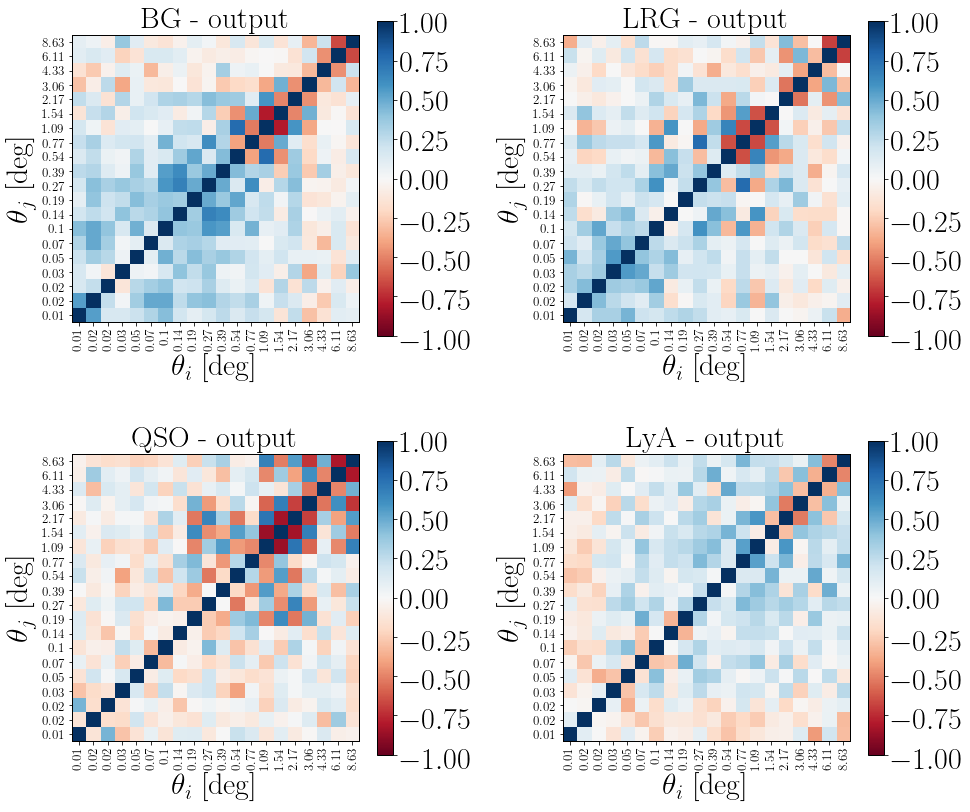

In [152]:
# look at the correlation matrix, calculated from covariance

catalogue = 'output' # ['input' or 'output']
statistic = 'wtheta' # ['wtheta', 'xi', or 'wp']

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation



if statistic == 'wtheta':
    label1 = r'$\theta_i$ [deg]'
    label2 = r'$\theta_j$ [deg]'
if statistic == 'xi':
    label1 = r'$r_i$ [Mpc/h]'
    label2 = r'$r_j$ [Mpc/h]'
if statistic == 'wp':
    label1 = r'$r_{p, i}$ [Mpc/h]'
    label2 = r'$r_{p, j}$ [Mpc/h]'

plt.figure(figsize=(14,12))

for i, tracer in enumerate(cat_vars.tracers):
    plt.subplot(2,2,i+1)
    plt.title('%s - %s'%(tracer, catalogue))
    plt.xlabel(label1)
    plt.ylabel(label2)


    # load covariance and get correlation matrix, then plot
    path = ''
    if catalogue == 'input':
        path += cat_vars.results_input + 'results_' + tracer + '_'
    else:
        path += cat_vars.results_output + 'results_' + tracer + '_'

    res = load_object(path + statistic)
    corr_m = correlation_from_covariance(res.cov_avg)

    plt.imshow(np.flip(corr_m, axis=0), cmap=plt.get_cmap('RdBu'), vmin=-1, vmax=1)
    plt.xticks(np.linspace(0,19,20), np.round(res.bin_mid,2), rotation='vertical', size=13)
    plt.yticks(np.linspace(0,19,20), np.flip(np.round(res.bin_mid,2)), size=13)
    
    plt.colorbar()


plt.tight_layout()
plt.savefig(cat_vars.plots_results + 'corr_matrix_' + catalogue + '_' + statistic + '.pdf', dpi=150, bbox_inches='tight')
plt.show()



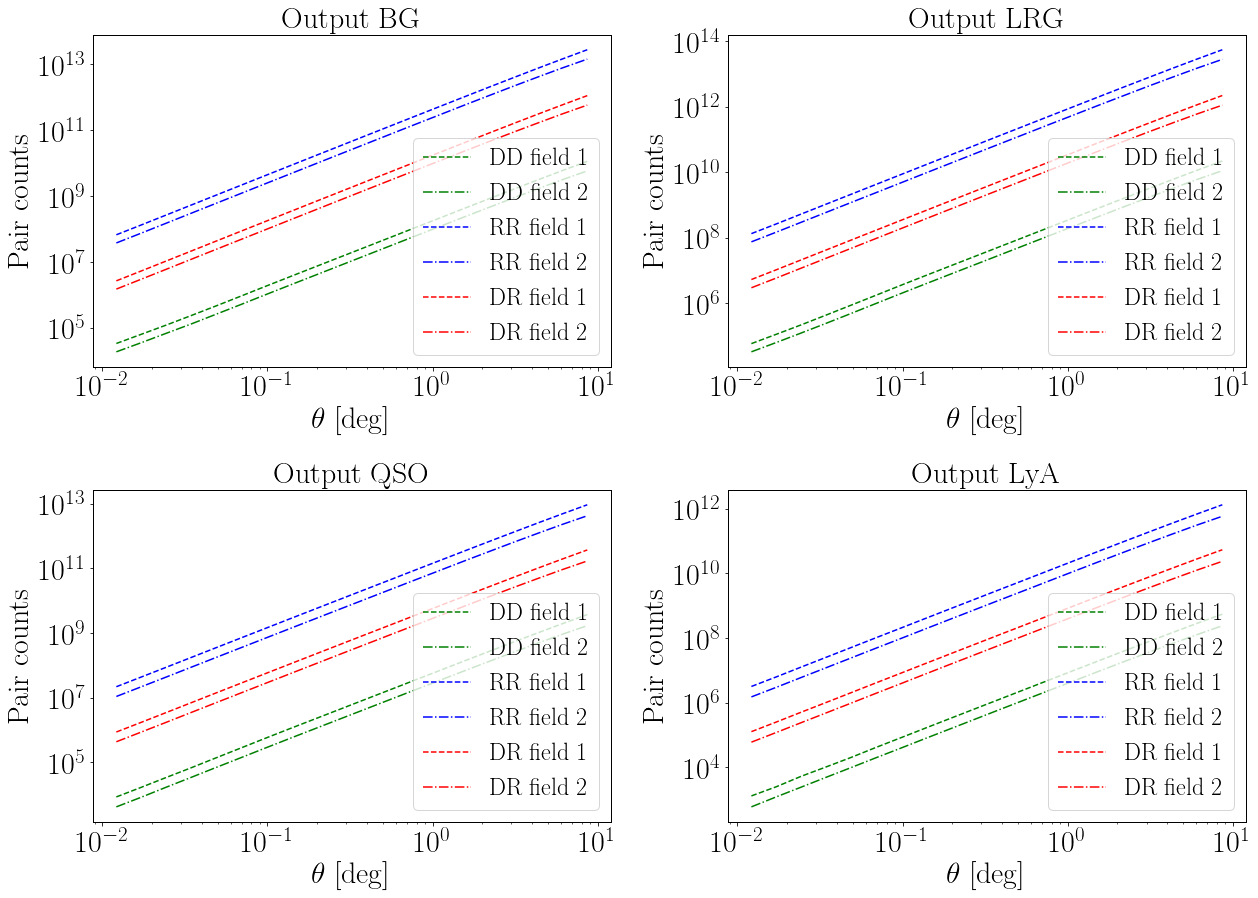

In [9]:
# plot the pair counts for output catalogues for w(theta) measurement

plt.figure(figsize=(18,13))

for i, tracer in enumerate(cat_vars.tracers):
    
    # load the results file
    res = load_object(cat_vars.results_output + 'results_' + tracer + '_wtheta')
    
    plt.subplot(2,2,i+1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Output %s'%(tracer))
    plt.xlabel(r'$\theta$ [deg]')
    plt.ylabel('Pair counts')
    
    plt.plot(res.bin_mid, res.DD1, c = 'green', ls='--', label='DD field 1')
    plt.plot(res.bin_mid, res.DD2, c = 'green', ls='-.', label='DD field 2')
    
    plt.plot(res.bin_mid, res.RR1, c = 'blue', ls='--', label='RR field 1')
    plt.plot(res.bin_mid, res.RR2, c = 'blue', ls='-.', label='RR field 2')
    
    plt.plot(res.bin_mid, res.DR1, c = 'red', ls='--', label='DR field 1')
    plt.plot(res.bin_mid, res.DR2, c = 'red', ls='-.', label='DR field 2')
    
    plt.legend()
    plt.tight_layout()
    
plt.show()  

# Now for some power spectrum plots

Running CAMB for redshift = 0
Getting linear and nonlinear spectra... done.


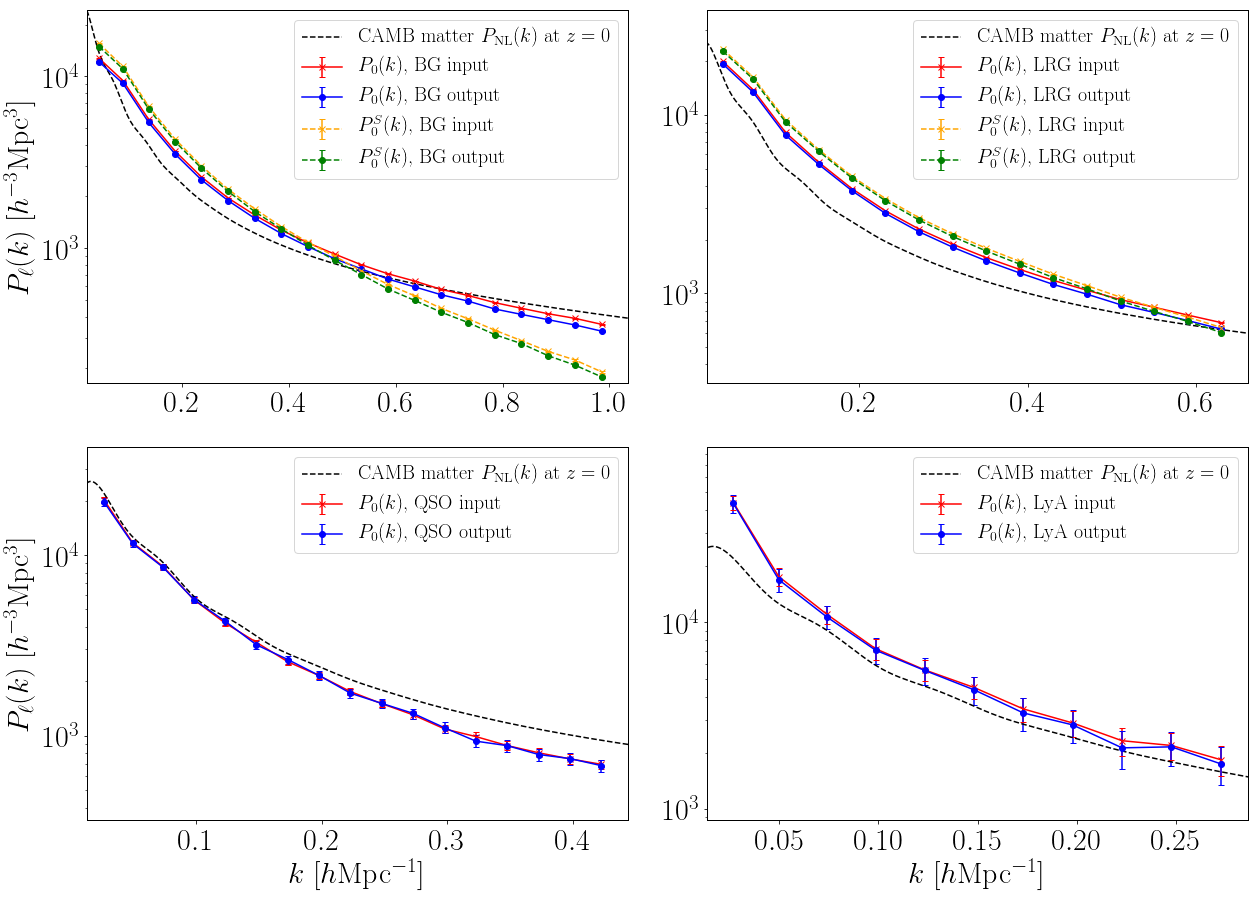

CPU times: user 3min 7s, sys: 1.46 s, total: 3min 9s
Wall time: 10.2 s


In [333]:
%%time

CAMB_0 = get_CAMB_power(redshift=0, cosmo=cat_vars.cosmo, camb_h=cat_vars.hubble_h)

# for loop to plot the P_l(k) results for the 4 tracers

Nmesh = 1024
plot_zspace = True
window='tsc'   # 'cic' or 'tsc'
custom_name = ''

plt.figure(figsize=(18,13))

for i, tracer in enumerate (cat_vars.tracers):
    
    plt.subplot(2,2,i+1)
    plt.yscale('log')
    if i > 1:
        plt.xlabel('$k$ [$h$Mpc$^{-1}$]')      
    if i % 2 == 0:
        plt.ylabel('$P_{\ell}(k)$ [$h^{-3}$Mpc$^3$]')
    #plt.title(r'Window conv. $P^{\rm Gal}_{\ell}(k)$ - %s'%(tracer))
    
    
    
        
    # load and plot the real space measurements
    results_file_in = cat_vars.results_input + 'results_' + tracer + '_pk_' + str(Nmesh) + '_' + window + custom_name
    res_pk_in = load_object(results_file_in)
    results_file_out = cat_vars.results_output + 'results_' + tracer + '_pk_' + str(Nmesh) + '_' + window + custom_name
    res_pk_out = load_object(results_file_out)
    
    bin0_in = res_pk_in.bin0
    bin0_out = res_pk_out.bin0
    
    plt.errorbar(bin0_in.bin_mid, bin0_in.Pk0, yerr=bin0_in.Pk0_err, capsize=3, color='red', marker='x', label='$P_0(k)$, %s input'%(tracer))
    plt.errorbar(bin0_out.bin_mid, bin0_out.Pk0, yerr=bin0_out.Pk0_err, capsize=3, color='blue', marker='o', label='$P_0(k)$, %s output'%(tracer))
    
    # set limits
    plt.xlim(np.amin(bin0_in.bin_mid)*0.5,np.amax(bin0_in.bin_mid)*1.05)
    plt.ylim(np.amin(bin0_out.Pk0)*0.5, np.amax(bin0_out.Pk0)*2)
    
    
    # plot redshift space
    if plot_zspace==True:
        if tracer in ['BG', 'LRG']:
            results_file_in = cat_vars.results_input + 'results_' + tracer + '_pk_' + str(Nmesh) + '_' + window + '_zspace' + custom_name
            res_pk_in = load_object(results_file_in)
            results_file_out = cat_vars.results_output + 'results_' + tracer + '_pk_' + str(Nmesh) + '_' + window + '_zspace' + custom_name
            res_pk_out = load_object(results_file_out)
            bin0_in = res_pk_in.bin0
            bin0_out = res_pk_out.bin0
            plt.errorbar(bin0_in.bin_mid, bin0_in.Pk0, yerr=bin0_in.Pk0_err, capsize=3, color='orange', marker='x', ls='--', label='$P^S_0(k)$, %s input'%(tracer))
            plt.errorbar(bin0_out.bin_mid, bin0_out.Pk0, yerr=bin0_out.Pk0_err, capsize=3, color='green', marker='o', ls='--', label='$P^S_0(k)$, %s output'%(tracer))
    
    
    
    # plot camb line
    plt.plot(CAMB_0.k_range, CAMB_0.nonlin_power, c='black', ls='--', label=r'CAMB matter $P_\mathrm{NL}(k)$ at $z=0$')

    
    plt.legend(loc=1, fontsize=20)

plt.tight_layout()
plt.savefig(cat_vars.plots_results + 'results_Pk.pdf', dpi=150, bbox_inches='tight')
plt.show()

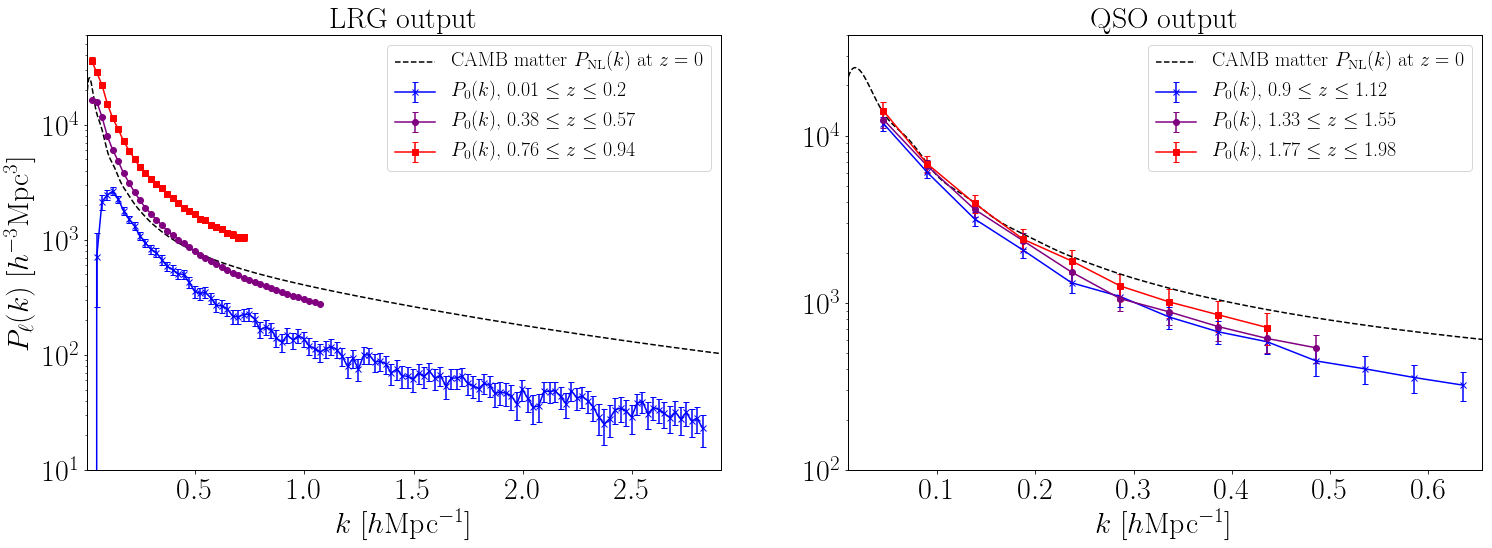

In [292]:
catalogue = 'output'
Nmesh = 1024
window = 'tsc'
real_or_redshift = 'real'
custom_name = ''

# camb_z = 0
# CAMB_0 = get_CAMB_power(redshift=camb_z, cosmo=cat_vars.cosmo, camb_h=cat_vars.hubble_h)

plt.figure(figsize=(25,8))

plt.subplot(1,2,1)
tracer = 'LRG'
plt.yscale('log')
plt.xlabel('$k$ [$h$Mpc$^{-1}$]')
plt.ylabel('$P_{\ell}(k)$ [$h^{-3}$Mpc$^3$]')
# plt.title('Window convolved galaxy $P(k)$ plot - %s %s'%(catalogue, tracer))
plt.title('%s %s'%(tracer, catalogue))

# load results and pull a few bin params
result_in = load_object(cat_vars.results_input + 'results_' + tracer + '_pk_' + str(Nmesh) + '_' + window + '_zbins' + custom_name)
bin0 = result_in.bin0
bin2 = result_in.bin2
bin4 = result_in.bin4

plt.xlim(np.amin(bin0.bin_mid)*0.2,np.amax(bin0.bin_mid)*1.03)
plt.ylim(1e1, 6e4)

plt.errorbar(bin0.bin_mid, bin0.Pk0, yerr=bin0.Pk0_err, capsize=3, marker='x', color='blue', label='$P_0(k)$, %s $\leq z \leq$ %s'%(round(bin0.Z_min, 2),round(bin0.Z_max, 2)))
plt.errorbar(bin2.bin_mid, bin2.Pk0, yerr=bin2.Pk0_err, capsize=3, marker='o', color='purple', label='$P_0(k)$, %s $\leq z \leq$ %s'%(round(bin2.Z_min, 2),round(bin2.Z_max, 2)))
plt.errorbar(bin4.bin_mid, bin4.Pk0, yerr=bin4.Pk0_err, capsize=3, marker='s', color='red', label='$P_0(k)$, %s $\leq z \leq$ %s'%(round(bin4.Z_min, 2),round(bin4.Z_max, 2)))

plt.plot(CAMB_0.k_range, CAMB_0.nonlin_power, c='black', ls='--', label=r'CAMB matter $P_\mathrm{NL}(k)$ at $z=%s$'%(camb_z))

plt.legend(fontsize=20)


plt.subplot(1,2,2)
tracer = 'QSO'
plt.yscale('log')
plt.xlabel('$k$ [$h$Mpc$^{-1}$]')
# plt.ylabel('$P_{\ell}(k)$ [$h^{-3}$Mpc$^3$]')
# plt.title('Window convolved galaxy $P(k)$ plot - %s %s'%(catalogue, tracer))
plt.title('%s %s'%(tracer, catalogue))

# load results and pull a few bin params
result_in = load_object(cat_vars.results_input + 'results_' + tracer + '_pk_' + str(Nmesh) + '_' + window + '_zbins' + custom_name)
bin0 = result_in.bin0
bin2 = result_in.bin2
bin4 = result_in.bin4

plt.xlim(np.amin(bin0.bin_mid)*0.2,np.amax(bin0.bin_mid)*1.03)
plt.ylim(1e2, 4e4)

plt.errorbar(bin0.bin_mid, bin0.Pk0, yerr=bin0.Pk0_err, capsize=3, marker='x', color='blue', label='$P_0(k)$, %s $\leq z \leq$ %s'%(round(bin0.Z_min, 2),round(bin0.Z_max, 2)))
plt.errorbar(bin2.bin_mid, bin2.Pk0, yerr=bin2.Pk0_err, capsize=3, marker='o', color='purple', label='$P_0(k)$, %s $\leq z \leq$ %s'%(round(bin2.Z_min, 2),round(bin2.Z_max, 2)))
plt.errorbar(bin4.bin_mid, bin4.Pk0, yerr=bin4.Pk0_err, capsize=3, marker='s', color='red', label='$P_0(k)$, %s $\leq z \leq$ %s'%(round(bin4.Z_min, 2),round(bin4.Z_max, 2)))

plt.plot(CAMB_0.k_range, CAMB_0.nonlin_power, c='black', ls='--', label=r'CAMB matter $P_\mathrm{NL}(k)$ at $z=%s$'%(camb_z))

plt.legend(fontsize=20)

plt.savefig(cat_vars.plots_results + 'results_Pk_zbins.pdf', dpi=150, bbox_inches='tight')

plt.show()